In [62]:
import numpy as np
import pandas as pd
from collections import defaultdict
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from sklearn.model_selection import train_test_split as tts
from surprise.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import ndcg_score
from surprise import dump
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from surprise import SVD
import random
import pickle
from copy import deepcopy

import typing as tp
from sklearn.preprocessing import normalize
from lightfm import LightFM
from scipy.sparse import coo_matrix
from lightfm.data import Dataset as LFMDataset
np.random.seed(42)

In [6]:
n_predict = 10

### Загрузка и обработка данных

In [12]:
df = pd.read_csv('../data/recsys-in-practice/train_joke_df.csv')

df

,UID,JID,Rating
0,18029,6,-1.26
1,3298,64,-4.17
2,3366,58,0.92
3,12735,92,3.69
4,11365,38,-6.60
...,...,...,...
1448359,22604,26,2.82
1448360,22255,36,-1.94
1448361,21056,40,-9.56
1448362,12328,97,0.87


In [13]:
# сделаем сортировку и перепишем index
df = df.sort_values(by=['UID', 'JID'])
df = df.reset_index(drop=True)

In [14]:
# создадим на основе набора данных
# поднабор, который требуется для библиотеки Surprise

# указываем минимальный и максимальный рейтинги
reader = Reader(rating_scale=(-10, 10))

# передаём набор, указывая последовательность колонок: user (raw) ids, item (raw) ids, ratings
# для Surprise - это обязательно
data = Dataset.load_from_df(df[['UID', 'JID', 'Rating']], reader)

In [15]:
trainset_data = data.build_full_trainset()

In [16]:
# сделаем разделение на обучающую и тестовую выборку
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [17]:
# обучим с лучшими параметрами
algo = SVD(random_state=0, n_epochs=100, n_factors= 512)
algo.fit(trainset)

# получим предикт и посмотрим метрику
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 4.0689


4.0689312503214765

In [19]:
file_name = '05_eline_svd_train'
dump.dump(file_name, algo=algo)
#_, algo = dump.load(file_name)

In [20]:
df_true = pd.DataFrame(testset, columns = ['UID', 'JID', 'Ratings'])
df_true

,UID,JID,Ratings
0,23488,100,-1.21
1,9825,21,0.68
2,6959,28,0.15
3,13758,100,9.27
4,19135,50,5.29
...,...,...,...
289668,4521,26,6.41
289669,24401,2,0.97
289670,2334,22,3.01
289671,11629,35,7.72


In [135]:
test_set_all = []
for u in range(1, 24983 + 1):
    for j in range(1, 100 + 1):
        test_set_all.append((u, j, 0))
        
predictions_all = algo.test(test_set_all)

In [136]:
df_pred_all = pd.DataFrame([(x[0], x[1], x[3]) for x in predictions_all], columns = ['UID', 'JID', 'Ratings_pred'])
df_pred_all

,UID,JID,Ratings_pred
0,1,1,-7.762274
1,1,2,8.601889
2,1,3,-9.288474
3,1,4,-8.308283
4,1,5,-7.359089
...,...,...,...
2498295,24983,96,3.937230
2498296,24983,97,3.891912
2498297,24983,98,2.506312
2498298,24983,99,1.544362


In [137]:
def get_n_recommendations_for_user(df, user_id, n):
    recommended_items = pd.DataFrame(df[df_pred_all['UID'] == user_id])
    recommended_items = recommended_items.sort_values('Ratings_pred', ascending=False)  
    return recommended_items.iloc[:n]

In [138]:
frames = []
for user in tqdm(users):
    frames.append(get_n_recommendations_for_user(df_pred_all, user, n_predict))
    
df_rec = pd.concat(frames).reset_index()
df_rec = df_rec.drop(columns=['index'])

  0%|          | 0/24975 [00:00<?, ?it/s]

In [139]:
df_rec

,UID,JID,Ratings_pred
0,1,2,8.601889
1,1,61,8.427860
2,1,54,8.155490
3,1,14,7.898142
4,1,27,7.028688
...,...,...,...
249745,24983,29,7.186592
249746,24983,68,7.176671
249747,24983,21,7.083931
249748,24983,87,7.070939


In [21]:
df_pred = pd.DataFrame([(x[0], x[1], x[2], x[3]) for x in predictions], columns = ['UID', 'JID', 'Ratings', 'Ratings_pred'])
df_pred

,UID,JID,Ratings,Ratings_pred
0,23488,100,-1.21,-0.829102
1,9825,21,0.68,1.546620
2,6959,28,0.15,-0.208726
3,13758,100,9.27,5.045077
4,19135,50,5.29,5.683031
...,...,...,...,...
289668,4521,26,6.41,1.756193
289669,24401,2,0.97,-0.243122
289670,2334,22,3.01,2.539018
289671,11629,35,7.72,3.528305


In [22]:
users = np.unique(df_pred['UID'])
users

array([    1,     2,     3, ..., 24981, 24982, 24983])

In [23]:
ndsg = {}

for user in tqdm(users):
    df_user = df_pred[df_pred['UID'] == user]
    
    
    if len(df_user) < 2:
        continue
    #display(df_user)
    #display(np.asarray([df_user['Ratings']]))
    ndsg[user] = ndcg_score(np.asarray([df_user['Ratings']]), np.asarray([df_user['Ratings_pred']]))
  

  0%|          | 0/24975 [00:00<?, ?it/s]

In [24]:
np.mean(list(ndsg.values()))

0.7675190352678675

In [25]:
df_pred = df_pred.merge(pd.DataFrame({'UID':ndsg.keys(), 'NDSG': list(ndsg.values())}), how='left')#
df_pred

,UID,JID,Ratings,Ratings_pred,NDSG
0,23488,100,-1.21,-0.829102,0.521271
1,9825,21,0.68,1.546620,5.696943
2,6959,28,0.15,-0.208726,1.917413
3,13758,100,9.27,5.045077,0.928378
4,19135,50,5.29,5.683031,0.968095
...,...,...,...,...,...
289668,4521,26,6.41,1.756193,0.070607
289669,24401,2,0.97,-0.243122,0.725005
289670,2334,22,3.01,2.539018,0.910031
289671,11629,35,7.72,3.528305,0.864036


In [26]:
df_pred[df_pred['NDSG'].isna()]

,UID,JID,Ratings,Ratings_pred,NDSG
11364,17079,12,-0.39,1.466131,NaN
12171,22591,18,-3.74,-2.065923,NaN
33060,19368,5,6.80,3.046478,NaN
40006,10549,8,1.17,-2.032211,NaN
41617,9696,17,2.18,0.241160,NaN
44695,7670,54,-8.20,-0.633874,NaN
45853,2227,45,-3.01,1.030955,NaN
47116,14537,18,4.95,0.900638,NaN
49371,742,28,2.28,2.136637,NaN
52309,2989,49,4.76,-4.059836,NaN


In [27]:
df_pred = df_pred.fillna(0)

In [28]:
df_pred[df_pred['NDSG'].isna()]

,UID,JID,Ratings,Ratings_pred,NDSG


In [29]:
df_pred['NDSG'].mean()

0.7393970840973073

In [30]:
pop = dict(df['UID'].value_counts())
pop

{786: 95,
 3571: 94,
 11932: 93,
 14224: 92,
 20285: 92,
 24859: 92,
 7798: 91,
 14170: 91,
 15735: 91,
 886: 91,
 13078: 91,
 22652: 91,
 15405: 91,
 23966: 91,
 24388: 91,
 12493: 91,
 15026: 91,
 6505: 90,
 14981: 90,
 12968: 90,
 11008: 90,
 16349: 90,
 11158: 90,
 21798: 90,
 6286: 90,
 22553: 90,
 18315: 90,
 23462: 90,
 22525: 90,
 1953: 90,
 962: 90,
 2098: 90,
 4733: 90,
 9990: 90,
 8793: 90,
 13920: 90,
 15987: 90,
 24608: 90,
 7476: 90,
 12992: 90,
 9407: 90,
 4403: 90,
 6536: 90,
 22080: 90,
 8144: 89,
 23273: 89,
 7870: 89,
 23301: 89,
 1862: 89,
 4985: 89,
 6264: 89,
 16985: 89,
 11536: 89,
 13438: 89,
 7344: 89,
 13804: 89,
 20761: 89,
 21324: 89,
 19970: 89,
 8665: 89,
 17809: 89,
 9604: 89,
 2766: 89,
 4333: 89,
 9143: 89,
 23983: 89,
 15812: 89,
 2861: 89,
 16605: 89,
 4251: 89,
 6254: 89,
 17817: 89,
 7255: 89,
 9814: 89,
 20512: 89,
 20059: 89,
 5275: 89,
 6601: 89,
 14874: 89,
 16944: 89,
 22015: 89,
 14373: 89,
 5357: 89,
 22799: 89,
 6894: 89,
 19400: 89,
 12372:

In [32]:
cf_recs = []

for user in tqdm(users):
    df_user = df_pred[df_pred['UID'] == user]
    

  0%|          | 0/24975 [00:00<?, ?it/s]

In [33]:
df_pred.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            289663, 289664, 289665, 289666, 289667, 289668, 289669, 289670,
            289671, 289672],
           dtype='int64', length=289673)

In [34]:
test = df_true.copy().groupby('UID', as_index=False)['JID'].agg({'Ratings': (lambda x: list(set(x)))}).sort_values('Ratings')
test = test.set_index("UID")
test

,Ratings
UID,
4426,"[1, 2, 3, 4, 6, 7, 10, 12, 46, 49, 50, 55, 56,..."
17356,"[1, 2, 3, 4, 36, 70, 71, 43, 45, 46, 18, 52, 5..."
2829,"[1, 2, 3, 5, 21, 22, 27, 34, 39, 43, 44, 58, 6..."
18876,"[1, 2, 3, 6, 8, 25, 30, 31, 32, 51, 52, 53, 63..."
24013,"[1, 2, 3, 6, 10, 12, 13, 14, 21, 26, 28, 37, 4..."
...,...
8057,"[100, 71, 9, 11, 80, 18, 53, 87, 90, 94]"
8193,"[100, 71, 10, 75, 12, 62, 31]"
13635,"[100, 71, 16, 17, 50, 83, 20, 52, 25, 28]"


In [35]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["Ratings_pred"]
    recommended_items = recommended_items.sort_values('Ratings_pred', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [36]:
cf_model = df_pred.pivot_table(index='UID', columns='JID', values='Ratings_pred').fillna(0)
cf_model

JID,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
UID,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-3.592147,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
2,0.000000,0.000000,5.045075,0.000000,0.000000,0.867803,0.000000,0.0,4.510542,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.95062,0.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,6.441023,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.404334,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
5,0.000000,3.133182,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.293147,0.0,...,0.0,0.0,0.0,0.0,2.208855,0.0,0.0,0.0,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979,1.994753,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
24980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.510823,0.0,3.371554,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0
24981,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0


In [37]:

cf_recs = []
for user in tqdm(test.index):
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

  0%|          | 0/24975 [00:00<?, ?it/s]

,Ratings,cf_predictions
UID,,
4426,"[1, 2, 3, 4, 6, 7, 10, 12, 46, 49, 50, 55, 56,...","[80, 65, 50, 6, 89, 78, 12, 87, 4, 46]"
17356,"[1, 2, 3, 4, 36, 70, 71, 43, 45, 46, 18, 52, 5...","[53, 36, 46, 45, 52, 70, 1, 2, 94, 61]"
2829,"[1, 2, 3, 5, 21, 22, 27, 34, 39, 43, 44, 58, 6...","[1, 27, 5, 81, 66, 91, 21, 62, 73, 72]"
18876,"[1, 2, 3, 6, 8, 25, 30, 31, 32, 51, 52, 53, 63...","[31, 53, 69, 6, 25, 32, 66, 52, 51, 2]"
24013,"[1, 2, 3, 6, 10, 12, 13, 14, 21, 26, 28, 37, 4...","[12, 72, 78, 89, 61, 93, 14, 6, 45, 21]"


In [38]:
# рекомендации по популярным 
popularity_recs = df['JID'].value_counts().head(10).index.tolist()

pop_recs = []
for user in tqdm(test.index):
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

  0%|          | 0/24975 [00:00<?, ?it/s]

,Ratings,cf_predictions,pop_predictions
UID,,,
4426,"[1, 2, 3, 4, 6, 7, 10, 12, 46, 49, 50, 55, 56,...","[80, 65, 50, 6, 89, 78, 12, 87, 4, 46]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]"
17356,"[1, 2, 3, 4, 36, 70, 71, 43, 45, 46, 18, 52, 5...","[53, 36, 46, 45, 52, 70, 1, 2, 94, 61]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]"
2829,"[1, 2, 3, 5, 21, 22, 27, 34, 39, 43, 44, 58, 6...","[1, 27, 5, 81, 66, 91, 21, 62, 73, 72]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]"
18876,"[1, 2, 3, 6, 8, 25, 30, 31, 32, 51, 52, 53, 63...","[31, 53, 69, 6, 25, 32, 66, 52, 51, 2]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]"
24013,"[1, 2, 3, 6, 10, 12, 13, 14, 21, 26, 28, 37, 4...","[12, 72, 78, 89, 61, 93, 14, 6, 45, 21]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]"


In [39]:
items = np.unique(df['JID'])
items

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [40]:
# рекомендации случайных
ran_recs = []
for user in tqdm(test.index):
    random_predictions = np.random.choice(items, 10)
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

  0%|          | 0/24975 [00:00<?, ?it/s]

,Ratings,cf_predictions,pop_predictions,random_predictions
UID,,,,
4426,"[1, 2, 3, 4, 6, 7, 10, 12, 46, 49, 50, 55, 56,...","[80, 65, 50, 6, 89, 78, 12, 87, 4, 46]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[52, 93, 15, 72, 61, 21, 83, 87, 75, 75]"
17356,"[1, 2, 3, 4, 36, 70, 71, 43, 45, 46, 18, 52, 5...","[53, 36, 46, 45, 52, 70, 1, 2, 94, 61]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[88, 100, 24, 3, 22, 53, 2, 88, 30, 38]"
2829,"[1, 2, 3, 5, 21, 22, 27, 34, 39, 43, 44, 58, 6...","[1, 27, 5, 81, 66, 91, 21, 62, 73, 72]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[2, 64, 60, 21, 33, 76, 58, 22, 89, 49]"
18876,"[1, 2, 3, 6, 8, 25, 30, 31, 32, 51, 52, 53, 63...","[31, 53, 69, 6, 25, 32, 66, 52, 51, 2]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[91, 59, 42, 92, 60, 80, 15, 62, 62, 47]"
24013,"[1, 2, 3, 6, 10, 12, 13, 14, 21, 26, 28, 37, 4...","[12, 72, 78, 89, 61, 93, 14, 6, 45, 21]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[62, 51, 55, 64, 3, 51, 7, 21, 73, 39]"


In [41]:
actual = test.Ratings.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [42]:

def _ark(actual: list, predicted: list, k=10) -> float:
    """
    average recall @ k.
   
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / len(actual)


def mark(actual: List[list], predicted: List[list], k=10) -> float:
    """
    mean average recall @ k.
 
    """
    if len(actual) != len(predicted):
        raise AssertionError("Length mismatched")

    return np.mean([_ark(a,p,k) for a,p in zip(actual, predicted)])


def mark_plot(mark_scores, model_names, k_range):
    """
    Plots the mean average recall at k for a set of models to compare.
    ----------
    mark_scores: list of lists
        list of list of mar@k scores over k. This list is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A mar@k plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #lineplot
    mark_df = pd.DataFrame(np.column_stack(mark_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mark_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Recall at K (MAR@K) Comparison')
    ax.set_ylabel('MAR@K')
    ax.set_xlabel('K')

    plt.show()


In [43]:
pop_mark = []
for K in np.arange(1, 20):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.01542874492360975,
 0.02430266056605863,
 0.030864217556223553,
 0.03634134694354824,
 0.04128731340625116,
 0.04573970191959,
 0.04982961627097653,
 0.05371751385750703,
 0.057397572859222604,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698,
 0.06108209870416698]

In [44]:
random_mark = []
for K in np.arange(1, 20):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.00975650733393417,
 0.015314920245364488,
 0.019221198661085896,
 0.022475206015603905,
 0.02520149743348196,
 0.027649470796030386,
 0.029867714671619885,
 0.03188237084283502,
 0.033831899394710846,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484,
 0.035589299405762484]

In [45]:
cf_mark = []
for K in np.arange(1, 20):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.09778550113245019,
 0.18791018059918493,
 0.269235911307439,
 0.3401304619357392,
 0.40067602257483603,
 0.4514343024944257,
 0.4929924980071681,
 0.5264208424495171,
 0.5530981492536671,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506,
 0.5740248759066506]

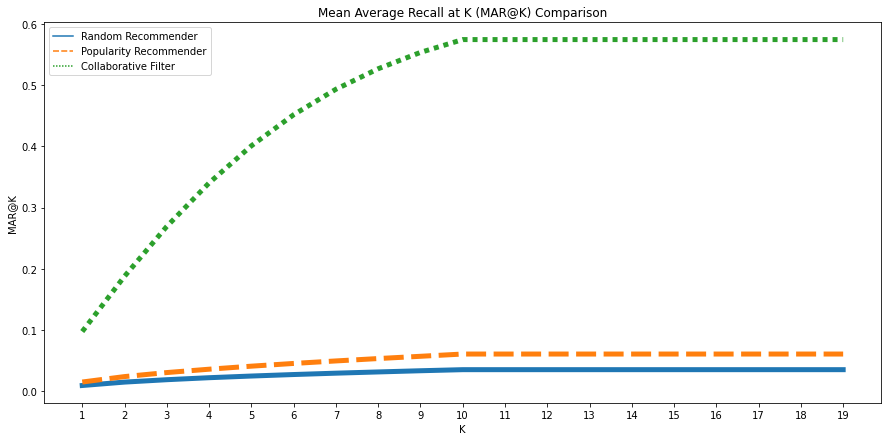

In [46]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,19+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
mark_plot(mark_scores, model_names=names, k_range=index)

In [47]:
df_test = pd.DataFrame(testset, columns = ['UID', 'JID', 'Ratings'])
display(df_test)

df_train = pd.DataFrame(trainset.all_ratings(), columns=['UID', 'JID', 'Ratings'])
display(df_train)

,UID,JID,Ratings
0,23488,100,-1.21
1,9825,21,0.68
2,6959,28,0.15
3,13758,100,9.27
4,19135,50,5.29
...,...,...,...
289668,4521,26,6.41
289669,24401,2,0.97
289670,2334,22,3.01
289671,11629,35,7.72


,UID,JID,Ratings
0,0,0,8.64
1,0,51,8.45
2,0,88,-9.27
3,0,52,6.12
4,0,10,6.55
...,...,...,...
1158686,24982,66,1.21
1158687,24982,22,9.13
1158688,24982,39,-0.29
1158689,24982,2,0.73


In [50]:
lfm_dataset = LFMDataset()
lfm_dataset.fit(
    users=df_train["UID"].values,
    items=df_train["JID"].values,
)

train_matrix, _ = lfm_dataset.build_interactions(zip(*df_train[["UID", "JID"]].values.T))

In [51]:
id_item_mapping = {v: k for k, v in lfm_dataset._item_id_mapping.items()}

In [53]:
lfm_model = LightFM(
    learning_rate=0.01, 
    loss='warp', 
    no_components=64,
    random_state=42
)
lfm_model.fit(
    interactions=train_matrix, 
    epochs=15,
    num_threads=20
);

In [54]:
with open('05_jokes_lfm_model.pkl', 'wb') as f:
    pickle.dump(lfm_model, f)

In [55]:
with open('05_jokes_lfm_dataset.pkl', 'wb') as f:
    pickle.dump(lfm_dataset, f)

In [58]:
lfm_model_cos = deepcopy(lfm_model)

lfm_model_cos.item_biases = np.zeros_like(lfm_model_cos.item_biases)
lfm_model_cos.user_biases = np.zeros_like(lfm_model_cos.user_biases)

lfm_model_cos.item_embeddings = normalize(lfm_model_cos.item_embeddings)
lfm_model_cos.user_embeddings = normalize(lfm_model_cos.user_embeddings)

In [95]:
def lfm_get_n_recommendations_for_user(
    user_id: str,
    model: LightFM,
    train_matrix: coo_matrix,
    user_to_id: tp.Dict[str, int],
    id_to_item: tp.Dict[int, str],
    n_recommendations: int,
    model_name: str
) -> pd.DataFrame:
    
    user_id = user_id - 1
    if model_name == 'random':
        return np.random.choice(df_train["JID"].values, n_recommendations)
    
    if model_name == 'popular':
        return list(df_train["JID"].value_counts()[:n_recommendations].index)
    
    user_inner_id = user_to_id[user_id]
    scores = model.predict(
        user_ids=user_inner_id,
        item_ids=np.arange(train_matrix.shape[1]),
        num_threads=20
    )
    user_watched_items = train_matrix.col[train_matrix.row == user_inner_id]
    scores[user_watched_items] = -np.inf

    recommended_item_inner_ids = np.argpartition(scores, -np.arange(n_recommendations))[
        -n_recommendations:
    ][::-1]
    recommended_item_ids = [id_to_item[x] + 1 for x in recommended_item_inner_ids]
    return recommended_item_ids


In [96]:
models_dict = {"lfm": lfm_model, "lfm_cos": lfm_model_cos, 'random':None, 'popular':None}

In [97]:
{x:lfm_dataset._user_id_mapping[x] for x in list(lfm_dataset._user_id_mapping.keys())[-10:]}

{24973: 24973,
 24974: 24974,
 24975: 24975,
 24976: 24976,
 24977: 24977,
 24978: 24978,
 24979: 24979,
 24980: 24980,
 24981: 24981,
 24982: 24982}

In [98]:
recommendations_dict = {}
for model_name, model in tqdm(models_dict.items()):
    recommendations = pd.DataFrame({"UID": df_test["UID"].unique()})
    recommendations["JID"] = recommendations["UID"].apply(
        lfm_get_n_recommendations_for_user,
        args=(
            model,
            train_matrix,
            lfm_dataset._user_id_mapping,
            id_item_mapping,
            n_predict,
            model_name
        ),
    )
    recommendations = recommendations.explode("JID")
    recommendations["rank"] = recommendations.groupby(["UID"]).cumcount() + 1
    recommendations_dict[model_name] = recommendations
    

  0%|          | 0/4 [00:00<?, ?it/s]

In [99]:
test

,Ratings,cf_predictions,pop_predictions,random_predictions
UID,,,,
4426,"[1, 2, 3, 4, 6, 7, 10, 12, 46, 49, 50, 55, 56,...","[80, 65, 50, 6, 89, 78, 12, 87, 4, 46]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[52, 93, 15, 72, 61, 21, 83, 87, 75, 75]"
17356,"[1, 2, 3, 4, 36, 70, 71, 43, 45, 46, 18, 52, 5...","[53, 36, 46, 45, 52, 70, 1, 2, 94, 61]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[88, 100, 24, 3, 22, 53, 2, 88, 30, 38]"
2829,"[1, 2, 3, 5, 21, 22, 27, 34, 39, 43, 44, 58, 6...","[1, 27, 5, 81, 66, 91, 21, 62, 73, 72]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[2, 64, 60, 21, 33, 76, 58, 22, 89, 49]"
18876,"[1, 2, 3, 6, 8, 25, 30, 31, 32, 51, 52, 53, 63...","[31, 53, 69, 6, 25, 32, 66, 52, 51, 2]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[91, 59, 42, 92, 60, 80, 15, 62, 62, 47]"
24013,"[1, 2, 3, 6, 10, 12, 13, 14, 21, 26, 28, 37, 4...","[12, 72, 78, 89, 61, 93, 14, 6, 45, 21]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[62, 51, 55, 64, 3, 51, 7, 21, 73, 39]"
...,...,...,...,...
8057,"[100, 71, 9, 11, 80, 18, 53, 87, 90, 94]","[53, 1, 61, 70, 69, 68, 67, 66, 65, 64]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[10, 8, 68, 2, 47, 28, 9, 35, 56, 20]"
8193,"[100, 71, 10, 75, 12, 62, 31]","[12, 62, 31, 75, 100, 71, 10, 58, 67, 74]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[61, 46, 26, 98, 94, 62, 55, 56, 47, 60]"
13635,"[100, 71, 16, 17, 50, 83, 20, 52, 25, 28]","[83, 50, 100, 17, 20, 52, 28, 95, 63, 72]","[7, 32, 16, 49, 18, 53, 21, 69, 15, 17]","[66, 22, 23, 62, 12, 12, 5, 90, 52, 54]"


In [100]:
actual = test.Ratings.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [101]:
actual = df_test.groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
actual

[[32, 67, 68, 9, 45, 78, 18, 52, 56, 24, 26, 29],
 [64, 99, 58, 3, 6, 9, 11, 76, 13, 79, 19, 84, 24, 26, 29],
 [66, 6, 76, 19, 21],
 [36, 7, 40, 48, 19, 20, 85, 56, 29, 62],
 [32, 33, 2, 66, 67, 39, 40, 9, 12, 50, 82, 86, 88, 25, 26, 57, 63, 95],
 [66, 7, 39, 8, 78, 18, 52, 87, 24, 57, 31],
 [96, 32, 35, 69, 40, 46, 19, 53, 26],
 [32, 97, 34, 2, 100, 33, 39, 40, 12, 78, 18, 52, 55, 90, 27, 28, 62],
 [37, 6, 7, 39, 5, 90, 11, 12, 74, 79, 49, 55, 58, 91, 61],
 [2, 34, 3, 43, 13, 51, 85, 26, 31, 30, 63],
 [66, 53, 7],
 [7,
  15,
  16,
  18,
  20,
  34,
  36,
  37,
  42,
  44,
  49,
  53,
  61,
  66,
  74,
  75,
  81,
  90,
  93,
  98],
 [32, 65, 66, 8, 43, 25, 93],
 [5,
  13,
  16,
  22,
  25,
  26,
  27,
  28,
  29,
  34,
  39,
  43,
  45,
  50,
  51,
  66,
  82,
  91,
  97,
  99],
 [65, 1, 99, 67, 37, 43, 76, 44, 78, 47, 16, 81, 84, 55, 57, 26, 27, 60],
 [65, 66, 67, 72, 73, 80, 18, 19, 30, 89, 59, 61, 62],
 [65, 34, 66, 35, 16, 17, 53, 29],
 [97, 67, 37, 6, 7, 10, 17, 53, 30, 90, 94],


In [102]:
lfm = recommendations_dict['lfm'].groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
lfm

[[65, 43, 76, 17, 82, 85, 56, 25, 60, 29],
 [34, 76, 44, 78, 79, 23, 90, 31, 94, 95],
 [36, 5, 6, 40, 73, 10, 11, 21, 87, 58],
 [96, 64, 97, 99, 100, 42, 78, 15, 30, 31],
 [3, 69, 38, 71, 8, 40, 73, 11, 54, 61],
 [66, 36, 70, 40, 73, 8, 45, 85, 55, 91],
 [67, 68, 5, 70, 46, 18, 54, 87, 88, 89],
 [65, 1, 10, 45, 81, 51, 20, 53, 55, 27],
 [1, 37, 73, 42, 12, 47, 50, 51, 28, 61],
 [2, 3, 7, 8, 43, 82, 86, 55, 28, 93],
 [68, 41, 9, 45, 46, 15, 48, 18, 21, 90],
 [100, 74, 75, 80, 84, 57, 90, 60, 63, 95],
 [96, 99, 100, 41, 25, 23, 57, 26, 61, 30],
 [2, 3, 5, 70, 7, 72, 40, 73, 45, 58],
 [1, 67, 69, 72, 10, 47, 83, 52, 58, 61],
 [96, 99, 7, 77, 85, 56, 90, 92, 94, 31],
 [65, 7, 73, 13, 81, 18, 87, 26, 93, 62],
 [32, 34, 7, 41, 77, 84, 25, 92, 93, 30],
 [67, 4, 6, 10, 43, 86, 87, 61, 62, 63],
 [33, 68, 37, 42, 43, 14, 85, 26, 91, 28],
 [34, 37, 6, 8, 12, 47, 80, 21, 89, 93],
 [67, 12, 47, 80, 83, 20, 53, 86, 87, 89],
 [66, 99, 41, 42, 46, 18, 29, 20, 24, 93],
 [1, 73, 42, 16, 21, 86, 87, 88, 

In [103]:
lfm_cos = recommendations_dict['lfm_cos'].groupby('UID', as_index=False)['JID'].agg({'JID': (lambda x: list(set(x)))}).sort_values('UID').JID.values.tolist()
lfm_cos

[[37, 76, 17, 82, 93, 85, 56, 25, 60, 29],
 [98, 76, 44, 78, 79, 95, 25, 90, 94, 31],
 [40, 73, 10, 11, 74, 19, 52, 21, 87, 58],
 [96, 97, 64, 99, 100, 13, 78, 15, 30, 31],
 [3, 69, 71, 8, 73, 40, 13, 52, 91, 61],
 [66, 36, 70, 40, 73, 13, 45, 52, 85, 91],
 [32, 67, 68, 5, 70, 46, 18, 54, 88, 26],
 [1, 65, 10, 45, 81, 51, 20, 53, 27, 63],
 [1, 37, 73, 42, 12, 81, 50, 51, 28, 61],
 [2, 3, 7, 8, 60, 82, 22, 86, 28, 93],
 [97, 98, 100, 39, 41, 46, 15, 48, 56, 90],
 [100, 39, 74, 75, 79, 84, 57, 90, 60, 95],
 [96, 99, 100, 41, 23, 22, 25, 57, 26, 30],
 [2, 3, 70, 7, 73, 45, 82, 85, 58, 28],
 [67, 26, 69, 10, 47, 83, 52, 58, 61, 31],
 [96, 99, 7, 77, 86, 56, 90, 92, 94, 31],
 [36, 7, 73, 13, 81, 18, 87, 26, 93, 62],
 [98, 35, 41, 77, 79, 84, 25, 31, 30, 95],
 [67, 4, 6, 10, 43, 12, 87, 61, 62, 63],
 [99, 35, 37, 100, 78, 49, 85, 56, 91, 28],
 [34, 37, 6, 12, 47, 82, 21, 28, 93, 30],
 [67, 100, 12, 83, 20, 53, 86, 87, 89, 31],
 [97, 66, 99, 98, 41, 76, 78, 48, 25, 93],
 [100, 75, 76, 15, 16,

In [105]:

def _precision(predicted, actual):
    prec = [value for value in predicted if value in actual]
    prec = float(len(prec)) / float(len(predicted))
    return prec

def _apk(actual: list, predicted: list, k=10) -> float:
    """
    average precision @ k.
    
    """
    #if not predicted or not actual:
    #    return 0.0
    
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    true_positives = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            max_ix = min(i + 1, len(predicted))
            score += _precision(predicted[:max_ix], actual)
            true_positives += 1
    
    if score == 0.0:
        return 0.0
    
    return score / true_positives


def mapk(actual: List[list], predicted: List[list], k: int=10) -> float:
    """
    mean average precision @ k.
    
    """
    if len(actual) != len(predicted):
        print(len(actual), len(predicted))
        raise AssertionError("Length mismatched")
    
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])


def mapk_plot(mapk_scores, model_names, k_range):
    """
    Plots the mean average precision at k for a set of models to compare.
    ----------
    mapk_scores: list of lists
        list of list of map@k scores over k. This lis is in same order as model_names
        example: [[0.17, 0.25, 0.76],[0.2, 0.5, 0.74]]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B']
    k_range: list
        list or array indeitifying all k values in order
        example: [1,2,3,4,5,6,7,8,9,10]
    Returns:
    -------
        A map@k plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #lineplot
    mapk_df = pd.DataFrame(np.column_stack(mapk_scores), k_range, columns=model_names)
    ax = sns.lineplot(data=mapk_df)
    plt.xticks(k_range)
    plt.setp(ax.lines,linewidth=5)

    #set labels
    ax.set_title('Mean Average Precision at K (MAP@K) Comparison')
    ax.set_ylabel('MAP@K')
    ax.set_xlabel('K')
    plt.show()

In [106]:

pop_mapk = []
for K in np.arange(1, 20):
    pop_mapk.extend([mapk(actual, pop_predictions, k=K)])


random_mapk = []
for K in np.arange(1, 20):
    random_mapk.extend([mapk(actual, random_predictions, k=K)])


cf_mapk = []
for K in np.arange(1, 20):
    cf_mapk.extend([mapk(actual, cf_predictions, k=K)])

In [107]:

lfm_mapk = []
for K in np.arange(1, 20):
    lfm_mapk.extend([mapk(actual, lfm, k=K)])
    

lfm_cos_mapk = []
for K in np.arange(1, 20):
    lfm_cos_mapk.extend([mapk(actual, lfm_cos, k=K)])

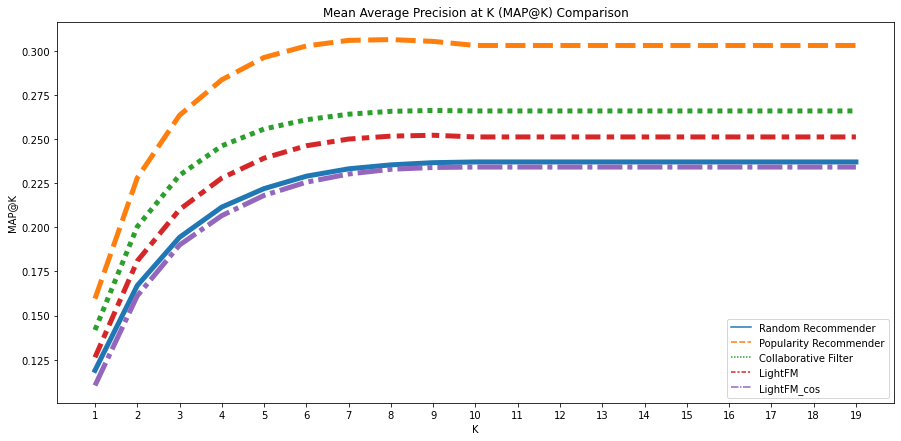

In [108]:
mapk_scores = [random_mapk, pop_mapk, cf_mapk, lfm_mapk, lfm_cos_mapk]
index = range(1,19+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'LightFM', 'LightFM_cos']

fig = plt.figure(figsize=(15, 7))
mapk_plot(mapk_scores, model_names=names, k_range=index)

In [110]:
def prediction_coverage(predicted: List[list], catalog: list, unseen_warning: bool=False) -> float:
    """
    Покрытие рекомендаций (по пользователю)
    
    ----------    
    Базируется на статье:
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    
    unique_items_catalog = set(catalog)
    if len(catalog)!=len(unique_items_catalog):
        raise AssertionError("Дубликаты в каталоге")

    predicted_flattened = [p for sublist in predicted for p in sublist]
    unique_items_pred = set(predicted_flattened)
    
    if not unique_items_pred.issubset(unique_items_catalog):
        if unseen_warning:
            warnings.warn("В рекомендациях есть элементы не из каталога. "
                "Игнорируем")
            unique_items_pred = unique_items_pred.intersection(unique_items_catalog)
        else:
            print(unique_items_pred - unique_items_catalog)
            raise AssertionError("В рекомендациях есть элементы не из каталога.")
    
    num_unique_predictions = len(unique_items_pred)
    prediction_coverage = round(num_unique_predictions/(len(catalog)* 1.0)* 100, 2)
    return prediction_coverage

In [111]:
random_coverage = prediction_coverage(ran_recs, items)
pop_coverage = prediction_coverage(pop_recs, items)
cf_coverage = prediction_coverage(cf_recs, items)
lfm_coverage = prediction_coverage(lfm, items)
lfm_cos_coverage = prediction_coverage(lfm_cos, items)

In [112]:
cf_recs

[[80, 65, 50, 6, 89, 78, 12, 87, 4, 46],
 [53, 36, 46, 45, 52, 70, 1, 2, 94, 61],
 [1, 27, 5, 81, 66, 91, 21, 62, 73, 72],
 [31, 53, 69, 6, 25, 32, 66, 52, 51, 2],
 [12, 72, 78, 89, 61, 93, 14, 6, 45, 21],
 [29, 2, 1, 3, 11, 60, 99, 65, 73, 72],
 [89, 66, 6, 86, 90, 64, 35, 92, 79, 45],
 [53, 35, 69, 79, 84, 82, 93, 88, 56, 6],
 [72, 80, 76, 96, 69, 65, 6, 26, 40, 29],
 [83, 88, 81, 77, 86, 100, 28, 12, 56, 1],
 [54, 35, 11, 21, 51, 66, 73, 72, 71, 70],
 [68, 49, 36, 61, 56, 12, 70, 69, 66, 65],
 [3, 32, 53, 62, 1, 9, 11, 69, 76, 75],
 [78, 21, 32, 12, 42, 99, 22, 90, 85, 1],
 [42, 35, 63, 88, 40, 11, 47, 54, 50, 96],
 [50, 36, 72, 49, 52, 70, 69, 68, 67, 65],
 [36, 76, 81, 21, 53, 68, 50, 66, 73, 72],
 [69, 36, 54, 38, 26, 2, 63, 1, 76, 81],
 [89, 1, 35, 66, 88, 48, 65, 94, 60, 69],
 [89, 73, 80, 76, 93, 96, 36, 97, 88, 31],
 [61, 3, 40, 51, 65, 74, 73, 72, 71, 70],
 [36, 51, 76, 74, 73, 72, 71, 70, 69, 68],
 [36, 8, 7, 1, 20, 23, 65, 68, 75, 74],
 [77, 31, 21, 36, 84, 26, 55, 99, 30,

In [128]:
random_coverage, pop_coverage, cf_coverage, lfm_coverage, lfm_cos_coverage

(100.0, 10.0, 100.0, 100.0, 100.0)

In [114]:

def catalog_coverage(predicted: List[list], catalog: list, k: int) -> float:
    """
    Покрытие рекомендаций (по каталогу)
    
    ----------
    Ge, M., Delgado-Battenfeld, C., & Jannach, D. (2010, September).
    Beyond accuracy: evaluating recommender systems by coverage and serendipity.
    In Proceedings of the fourth ACM conference on Recommender systems (pp. 257-260). ACM.
    """
    sampling = random.choices(predicted, k=k)
    predicted_flattened = [p for sublist in sampling for p in sublist]
    L_predictions = len(set(predicted_flattened))
    catalog_coverage = round(L_predictions/(len(catalog)*1.0)*100,2)
    return catalog_coverage



def coverage_plot(coverage_scores: list, model_names: list) -> None:
    """
    Plots the coverage for a set of models to compare.
    ----------
    coverage_scores: list
        list of coverage scores in same order as model_names
        example: [0.17, 0.25, 0.76]
    model_names: list
        list of model names in same order as coverage_scores
        example: ['Model A', 'Model B', 'Model C']
    Returns:
    -------
        A coverage plot
    """
    #create palette
    #recommender_palette = ["#ED2BFF", "#14E2C0", "#FF9F1C", "#5E2BFF","#FC5FA3"]
    #sns.set_palette(recommender_palette)

    #make barplot
    ax = sns.barplot(x=model_names, y=coverage_scores)

    #set labels
    ax.set_title('Catalog Coverage in %')
    ax.set_ylabel('coverage')

    plt.show()

In [130]:
# N=100 для определенного 
random_cat_coverage = catalog_coverage(ran_recs, items, 100)
pop_cat_coverage = catalog_coverage(pop_recs, items, 100)
cf_cat_coverage = catalog_coverage(cf_recs, items, 100)
lfm_cat_coverage = catalog_coverage(lfm, items, 100)
lfm_cat_cos_coverage = catalog_coverage(lfm_cos, items, 100)

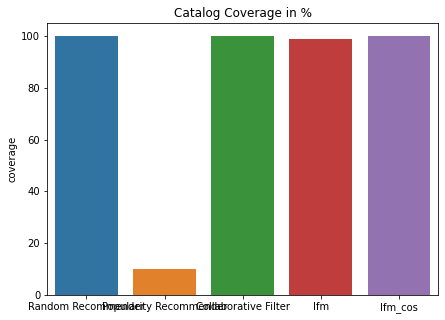

In [131]:
# визуализация
coverage_scores = [random_coverage, pop_coverage, cf_coverage, lfm_cat_coverage, lfm_cat_cos_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter', 'lfm', 'lfm_cos']

fig = plt.figure(figsize=(7, 5))
coverage_plot(coverage_scores, model_names)

In [117]:
def novelty(predicted: List[list], pop: dict, u: int, n: int) -> (float, list):
    """
    Новизна рекомендаций 
    ----------    
    Базируется на статье:
    Zhou, T., Kuscsik, Z., Liu, J. G., Medo, M., Wakeling, J. R., & Zhang, Y. C. (2010).
    Solving the apparent diversity-accuracy dilemma of recommender systems.
    Proceedings of the National Academy of Sciences, 107(10), 4511-4515.
    """
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        for i in sublist:
            self_information += np.sum(-np.log2(pop[i]/u))
        mean_self_information.append(self_information/n)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information


In [118]:
nov = df.JID.value_counts()
pop = dict(nov)

In [132]:
random_novelty,random_mselfinfo_list = novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = novelty(cf_recs, pop, len(users), 10)
lfm_novelty,lfm_mselfinfo_list = novelty(lfm, pop, len(users), 10)
lfm_cos_novelty,lfm_cos_mselfinfo_list = novelty(lfm_cos, pop, len(users), 10)

In [134]:
print(random_novelty, pop_novelty, cf_novelty, lfm_novelty, lfm_cos_novelty)

0.8911288565788048 0.31889467358820295 0.8569323179378326 0.8273331463685554 0.9129275863491108


In [122]:
test_set_all

[(1, 1, 0),
 (1, 2, 0),
 (1, 3, 0),
 (1, 4, 0),
 (1, 5, 0),
 (1, 6, 0),
 (1, 7, 0),
 (1, 8, 0),
 (1, 9, 0),
 (1, 10, 0),
 (1, 11, 0),
 (1, 12, 0),
 (1, 13, 0),
 (1, 14, 0),
 (1, 15, 0),
 (1, 16, 0),
 (1, 17, 0),
 (1, 18, 0),
 (1, 19, 0),
 (1, 20, 0),
 (1, 21, 0),
 (1, 22, 0),
 (1, 23, 0),
 (1, 24, 0),
 (1, 25, 0),
 (1, 26, 0),
 (1, 27, 0),
 (1, 28, 0),
 (1, 29, 0),
 (1, 30, 0),
 (1, 31, 0),
 (1, 32, 0),
 (1, 33, 0),
 (1, 34, 0),
 (1, 35, 0),
 (1, 36, 0),
 (1, 37, 0),
 (1, 38, 0),
 (1, 39, 0),
 (1, 40, 0),
 (1, 41, 0),
 (1, 42, 0),
 (1, 43, 0),
 (1, 44, 0),
 (1, 45, 0),
 (1, 46, 0),
 (1, 47, 0),
 (1, 48, 0),
 (1, 49, 0),
 (1, 50, 0),
 (1, 51, 0),
 (1, 52, 0),
 (1, 53, 0),
 (1, 54, 0),
 (1, 55, 0),
 (1, 56, 0),
 (1, 57, 0),
 (1, 58, 0),
 (1, 59, 0),
 (1, 60, 0),
 (1, 61, 0),
 (1, 62, 0),
 (1, 63, 0),
 (1, 64, 0),
 (1, 65, 0),
 (1, 66, 0),
 (1, 67, 0),
 (1, 68, 0),
 (1, 69, 0),
 (1, 70, 0),
 (1, 71, 0),
 (1, 72, 0),
 (1, 73, 0),
 (1, 74, 0),
 (1, 75, 0),
 (1, 76, 0),
 (1, 77, 0),
 (1, 78,

In [123]:
predictions_all

[Prediction(uid=1, iid=1, r_ui=0, est=-7.762274448033335, details={'was_impossible': False}),
 Prediction(uid=1, iid=2, r_ui=0, est=8.601888638550971, details={'was_impossible': False}),
 Prediction(uid=1, iid=3, r_ui=0, est=-9.288474030057374, details={'was_impossible': False}),
 Prediction(uid=1, iid=4, r_ui=0, est=-8.308283296416315, details={'was_impossible': False}),
 Prediction(uid=1, iid=5, r_ui=0, est=-7.3590893827191195, details={'was_impossible': False}),
 Prediction(uid=1, iid=6, r_ui=0, est=-8.160144659488333, details={'was_impossible': False}),
 Prediction(uid=1, iid=7, r_ui=0, est=-9.360691824617891, details={'was_impossible': False}),
 Prediction(uid=1, iid=8, r_ui=0, est=3.5941488027817394, details={'was_impossible': False}),
 Prediction(uid=1, iid=9, r_ui=0, est=-3.5921465784899045, details={'was_impossible': False}),
 Prediction(uid=1, iid=10, r_ui=0, est=-4.554169093564898, details={'was_impossible': False}),
 Prediction(uid=1, iid=11, r_ui=0, est=-3.0135955267885435

,UID,JID,Ratings_pred
0,1,1,-7.762274
1,1,2,8.601889
2,1,3,-9.288474
3,1,4,-8.308283
4,1,5,-7.359089
...,...,...,...
2498295,24983,96,3.937230
2498296,24983,97,3.891912
2498297,24983,98,2.506312
2498298,24983,99,1.544362


In [126]:
get_n_recommendations_for_user(df_pred_all, 4, 10)

,UID,JID,Ratings_pred
301,4,2,8.291101
313,4,14,7.837829
364,4,65,7.693970
333,4,34,7.325840
310,4,11,7.123855
338,4,39,7.092233
367,4,68,7.009037
345,4,46,6.614534
330,4,31,6.514432
327,4,28,6.439908


  0%|          | 0/24975 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df_rec

In [ ]:
def get_value_popularity_ranks(values: pd.Series) -> pd.Series:
    value_counts = values.value_counts()
    counts_unique = value_counts.unique()
    count_rank_mapping = pd.Series(index=counts_unique, data=np.arange(len(counts_unique)) + 1)
    return value_counts.map(count_rank_mapping)


def calculate_serendipity_per_user(
    recommendations: pd.DataFrame,
    train: pd.DataFrame,
    test: pd.DataFrame,
) -> pd.Series:
    recommendations_ = pd.merge(recommendations, test[["UID", "JID"]], how="left", indicator=True)
    recommendations_["is_rel"] = np.where(recommendations_["_merge"] == "both", 1, 0)

    n_items = train["JID"].nunique()
    item_popularity_ranks = get_value_popularity_ranks(train["JID"])
    recommendations_["rank_pop"] = recommendations_["JID"].map(item_popularity_ranks)

    recommendations_["proba_user"] = (n_items + 1 - recommendations_["Ratings_pred"]) / n_items
    recommendations_["proba_any_user"] = (n_items + 1 - recommendations_["rank_pop"]) / n_items

    recommendations_["proba_diff"] = np.maximum(
        recommendations_["proba_user"] - recommendations_["proba_any_user"],
        0.0
    )
    recommendations_["item_serendipity"] = recommendations_["proba_diff"] * recommendations_["is_rel"]
    return recommendations_[["UID", "item_serendipity"]].groupby("UID").agg("mean")


In [ ]:
recommendations_ = pd.merge(df_rec, df_test[["UID", "JID"]], how="left", indicator=True)
recommendations_["is_rel"] = np.where(recommendations_["_merge"] == "both", 1, 0)

n_items = df_train["JID"].nunique()
item_popularity_ranks = get_value_popularity_ranks(df_train["JID"])
recommendations_["rank_pop"] = recommendations_["JID"].map(item_popularity_ranks)

recommendations_["proba_user"] = (n_items + 1 - recommendations_["Ratings_pred"]) / n_items
recommendations_["proba_any_user"] = (n_items + 1 - recommendations_["rank_pop"]) / n_items

recommendations_["proba_diff"] = np.maximum(
    recommendations_["proba_user"] - recommendations_["proba_any_user"],
    0.0
)
recommendations_["item_serendipity"] = recommendations_["proba_diff"] * recommendations_["is_rel"]
recommendations_[["UID", "item_serendipity"]].groupby("UID").agg("mean")

In [ ]:

recommendations_[recommendations_['is_rel'] > 0]

In [ ]:
calculate_serendipity_per_user(df_rec, df_train, df_test).mean()

In [ ]:
calculate_serendipity_per_user(df_pred, df_train, df_test).mean()